<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/umap-fashion-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import codecs
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import tensorflow as tf
import colorsys
import umap
from mpl_toolkits.mplot3d import Axes3D

tfk = tf.keras

rc = {
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 6),
    'grid.linewidth': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 14,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 14,
}
sns.set('notebook', 'whitegrid', rc=rc)

## Data

In [2]:
(train_images, train_labels), (test_images, test_labels) = tfk.datasets.fashion_mnist.load_data()

X, Y = np.concatenate((train_images,test_images)), np.concatenate((train_labels,test_labels))

names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [25]:
colors = sns.color_palette('tab10')

def scale_lightness(rgb, scale_l=0.5):
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

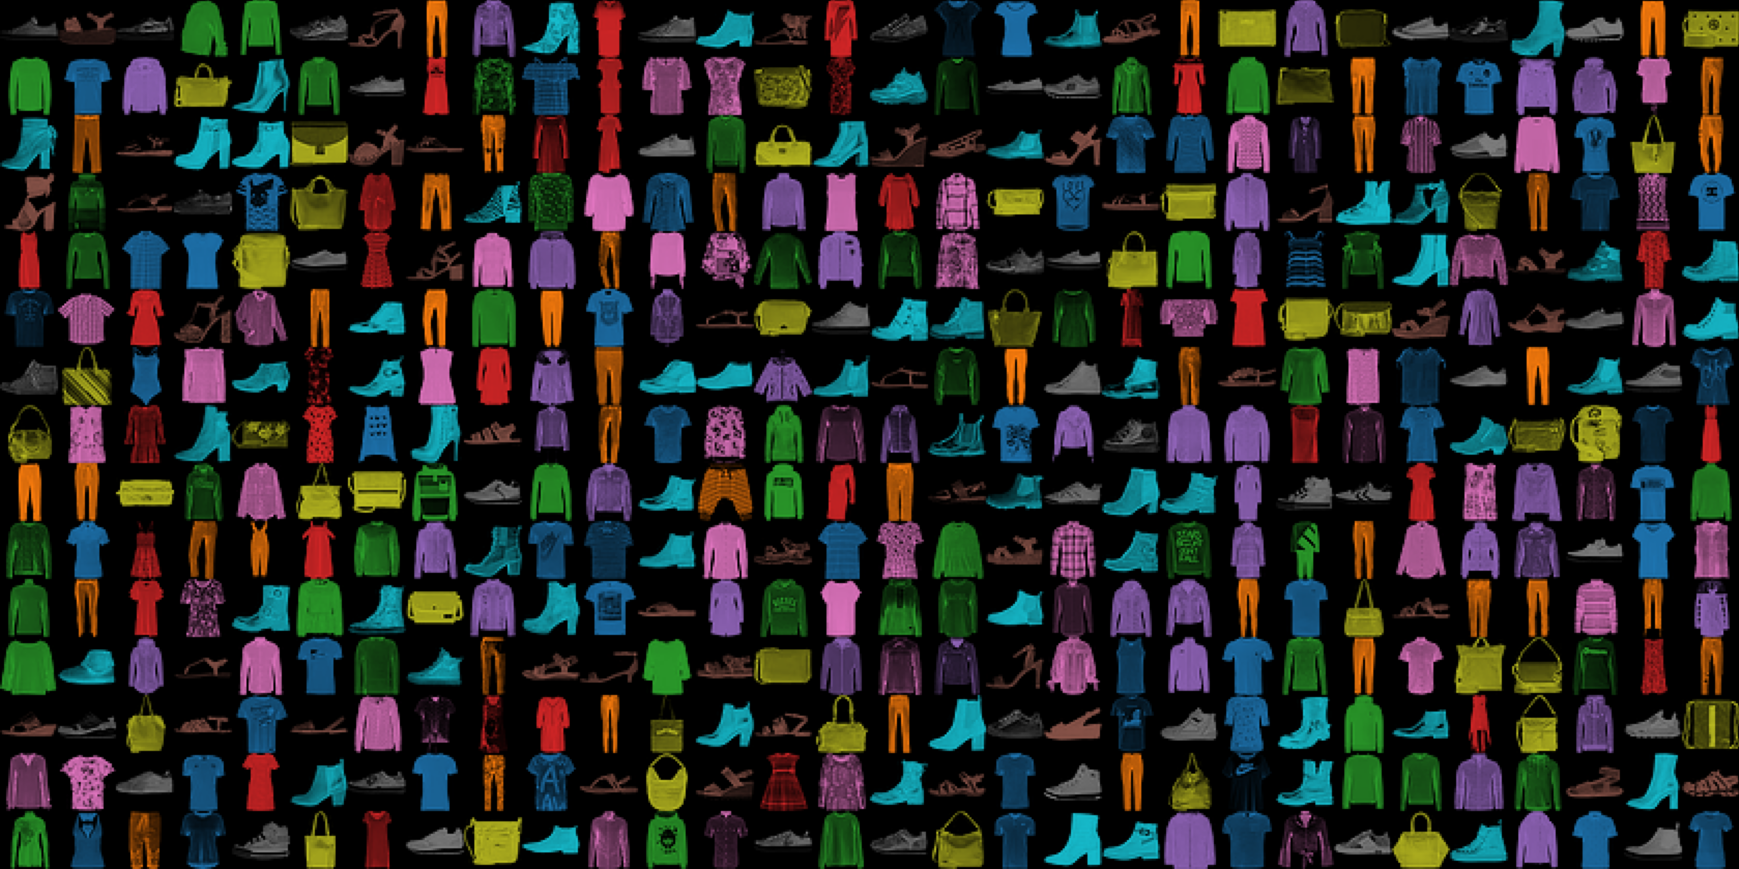

In [45]:
size, dim = 28, np.array([15,30])
n = dim[0] * dim[1]
rnd = np.random.permutation(X.shape[0])

fig, ax = plt.subplots(figsize=(16,8))

img = np.zeros((size * dim[0], size * dim[1], 3),dtype='uint8')

for d, t, i in zip(X[rnd[:n]], Y[rnd[:n]], range(n)):
    ix, iy = divmod(i, dim[1])
    img[ix*size:(ix+1)*size,iy*size:(iy+1)*size,:] = np.dstack((d,d,d)) * colors[t]

ax.imshow(img)
ax.set_axis_off()

with plt.rc_context({"savefig.pad_inches": 0}):
    plt.show()

## UMAP

### 2D

In [47]:
n = 70000
x_data, y_data = X.reshape(-1,28*28), Y

In [48]:
%time embedding = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2).fit_transform(x_data)
embedding -= np.mean(embedding,axis=0)

CPU times: user 2min 20s, sys: 3.56 s, total: 2min 24s
Wall time: 53.4 s


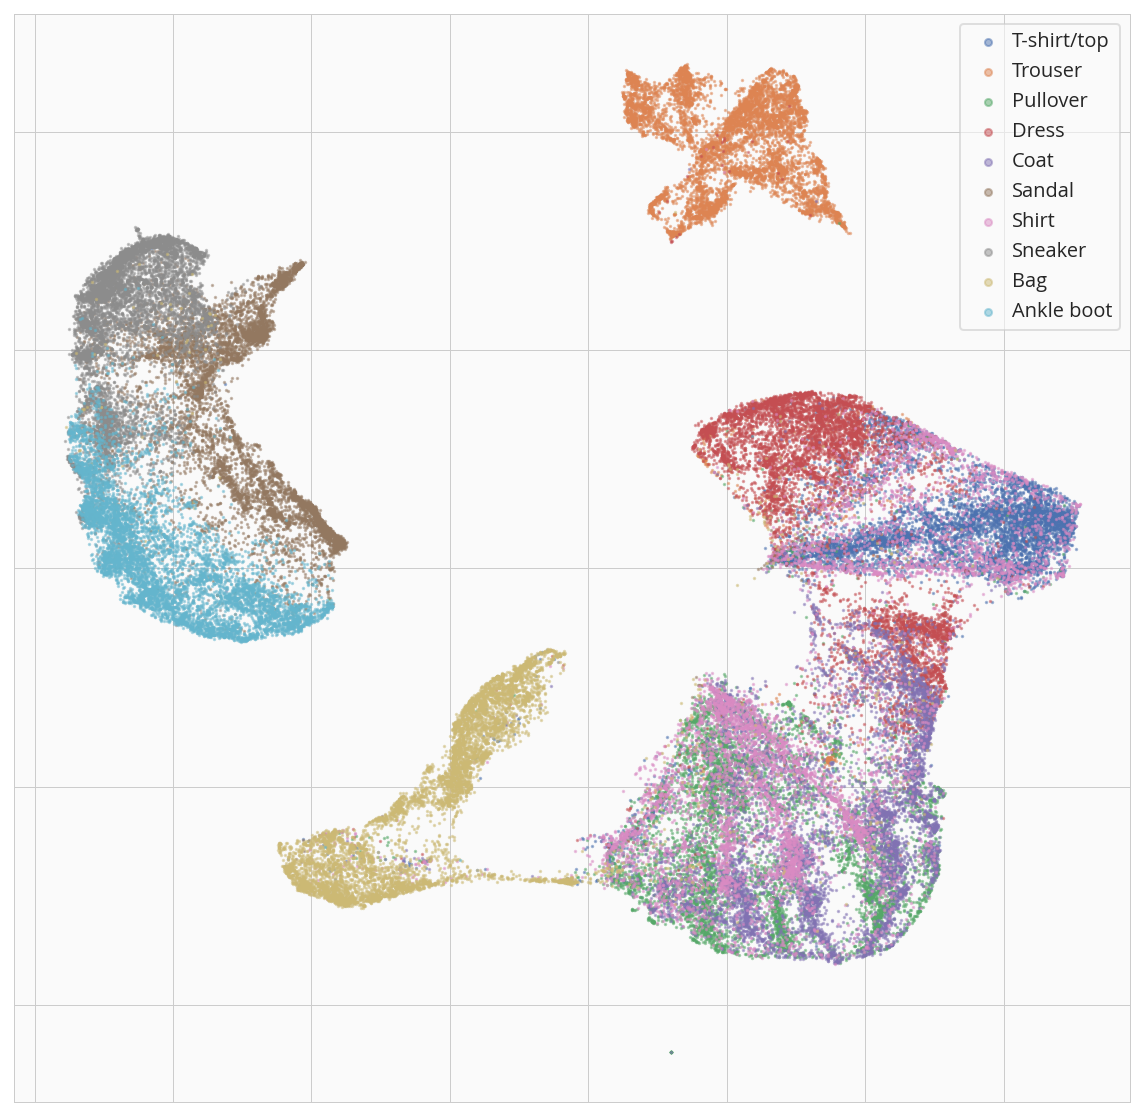

In [49]:
fig, ax = plt.subplots(figsize=(10,10))

for i in range(10):
    ax.scatter(embedding[y_data==i,0],
               embedding[y_data==i,1],
               cmap='tab10',marker='o',s=.5,
               alpha=0.5,
               label=names[i])

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc='upper right',markerscale=5)
ax.grid(True)

plt.show()

### 3D

In [50]:
%time embedding = umap.UMAP(n_neighbors=15, min_dist=0.2, n_components=3).fit_transform(x_data)
embedding -= np.mean(embedding,axis=0)

CPU times: user 2min 40s, sys: 3.03 s, total: 2min 43s
Wall time: 51.6 s


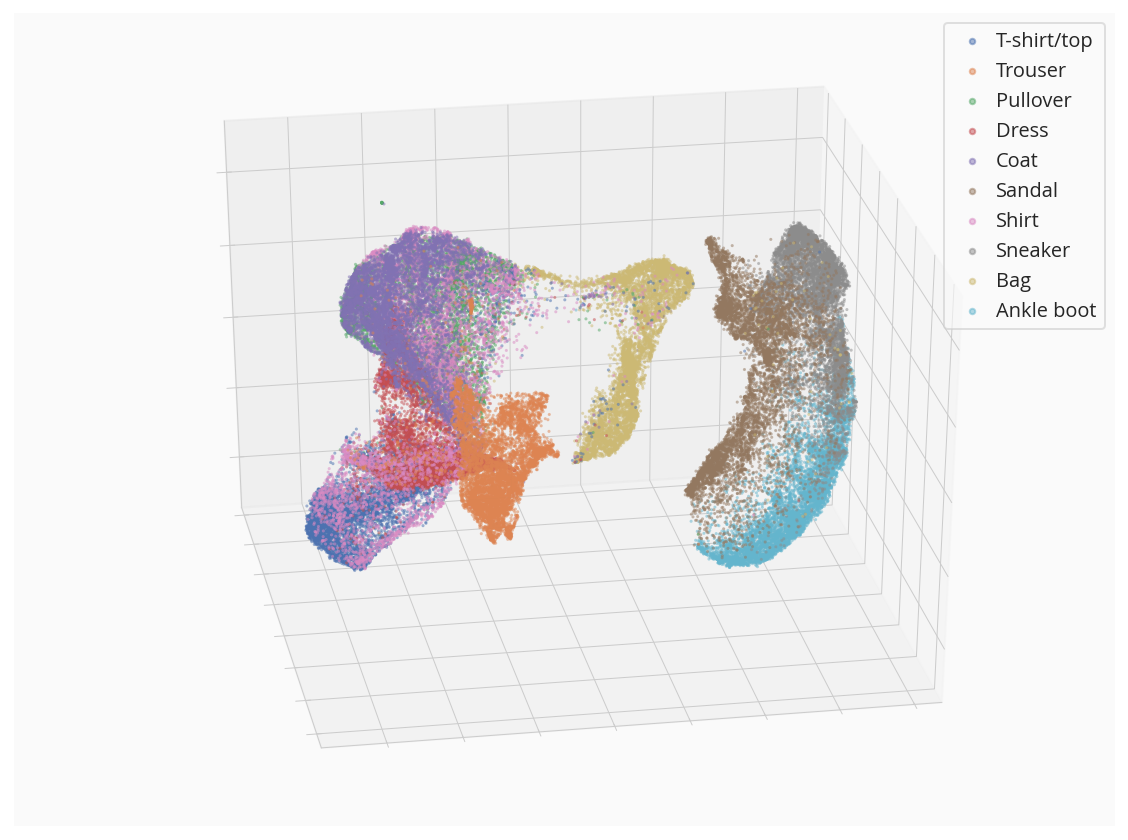

In [41]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

for i in range(10):
    ax.scatter(embedding[y_data==i,0],
               embedding[y_data==i,1],
               embedding[y_data==i,2],
               cmap='tab10',marker='o',s=.3,
               alpha=0.5,label=names[i])
    
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.tick_params(color='0.8')
ax.legend(loc='upper right',markerscale=5)
ax.view_init(30,80)

plt.tight_layout()
plt.show()

## Exports

### Embedding

In [188]:
json.dump({
    'position': embedding.tolist(),
    'label': Y.tolist()
}, codecs.open("embedding.json", 'w', encoding='utf-8'))

### Texture

In [51]:
canvas_size, size = 8192, 28
step = canvas_size // size

dim = np.array([step, step])


img = np.zeros((canvas_size, canvas_size),dtype='uint8')

for i in range(min(dim.prod(), X.shape[0])):
    ix, iy = divmod(i, dim[1])
    img[ix*size:(ix+1)*size,iy*size:(iy+1)*size] = X[i]

plt.imsave("texture.png", img, cmap="gray");

## Next Steps

### Generate [Draco](https://github.com/google/draco) Encoded Embedding

Save the following content to a `encoder.js` file.

```javascript
'use_strict';

const fs = require('fs');
const draco3d = require('draco3d');
const encoderModule = draco3d.createEncoderModule({});

fs.readFile("./embedding.json", function (err, buf) {
  if (err) {
    return console.log(err);
  }

  const data = JSON.parse(buf);
  const numPoints = data.position.length;
  const vertices = data.position.flat(1);
  const label = data.label;

  const encoder = new encoderModule.Encoder();
  const metaBuilder = new encoderModule.MetadataBuilder();
  const builder = new encoderModule.PointCloudBuilder();
  const mesh = new encoderModule.PointCloud();

  console.log("Adding attributes...");
  // position attribute
  builder.AddFloatAttribute(mesh, encoderModule.POSITION, numPoints, 3, new Float32Array(vertices));
  // label attribute
  const attrId1 = builder.AddUInt8Attribute(mesh, encoderModule.GENERIC, numPoints, 1, new Uint8Array(label));
  const attrMeta = new encoderModule.Metadata();
  metaBuilder.AddStringEntry(attrMeta, "name", "label");
  builder.SetMetadataForAttribute(mesh, attrId1, attrMeta);
  // index attribute
  const indices = Array.from({ length: numPoints }, (_, i) => i);
  const attrId2 = builder.AddUInt32Attribute(mesh, encoderModule.GENERIC, numPoints, 1, new Uint32Array(indices));
  const attrMeta2 = new encoderModule.Metadata();
  metaBuilder.AddStringEntry(attrMeta2, "name", "index");
  builder.SetMetadataForAttribute(mesh, attrId2, attrMeta2);

  // encode
  const encodedData = new encoderModule.DracoInt8Array();
  // Set encoding options.
  encoder.SetSpeedOptions(5, 5);
  encoder.SetAttributeQuantization(encoderModule.POSITION, 10);
  encoder.SetTrackEncodedProperties(true);
  encoder.SetEncodingMethod(encoderModule.MESH_EDGEBREAKER_ENCODING);

  console.log("Encoding...");
  const encodedLen = encoder.EncodePointCloudToDracoBuffer(mesh, false, encodedData);
  encoderModule.destroy(mesh);
  console.log(`Encoded ... ${encodedLen} bytes`);

  // Copy encoded data to buffer.
  const outputBuffer = new ArrayBuffer(encodedLen);
  const outputData = new Int8Array(outputBuffer);
  for (let i = 0; i < encodedLen; ++i) {
    outputData[i] = encodedData.GetValue(i);
  }
  encoderModule.destroy(encodedData);
  encoderModule.destroy(encoder);
  encoderModule.destroy(builder);
  encoderModule.destroy(metaBuilder);

  // Write to file. You can view the the file using webgl_loader_draco.html
  const outputFile = "embedding.drc";
  console.log(`Save to file ${outputFile}`);
  fs.writeFileSync(outputFile, Buffer.from(outputBuffer), "binary");
  console.log("Done!");
});
```

Run it with Node.js

```sh
$ node -v
v12.18.4
$ yarn add draco3d
$ node ./encode.js
Adding attributes...
Encoding...
Encoded ... 325522 bytes
Save to file embedding.drc
Done!
```

The `embedding.drc` is the embedding file.

### Generate Basis GPU Texture

#### Install [Basis Compression Tool](https://github.com/BinomialLLC/basis_universal)

```sh
$ git clone https://github.com/BinomialLLC/basis_universal.git
$ cmake CMakeLists.txt
$ make
```

#### Compress Texture

```sh
$ bin_osx/basisu fashion_mnist.png -comp_level 5 -max_endpoints 16128 -max_selectors 16128 -no_selector_rdo -no_endpoint_rdo -mipmap -q 255
```

The result is a `fashion_mnist.basis` file.